In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

In [2]:
X, y = load_boston().data, load_boston().target.reshape(-1,1)

In [3]:
X.shape, y.shape

((506, 13), (506, 1))

In [15]:
class NN_Build(object):
    def __init__(self, eta = 0.0005, iterations = 1000, activation = "relu", epsilon = 0.01, kernel_init = 'he_init', 
                 dims = [X.shape[1],30,5,1], lam = 0.9, beta = 0.9, beta2 = 0.9, epsilon_beta = 0.0000000001):
        self.eta = eta
        self.iterations = iterations
        self.activation = activation
        self.epsilon = epsilon
        self.kernel_init = kernel_init
        self.dims = dims
        self.layer = len(dims)
        self.lam = lam
        self.beta = beta
        self.beta2 = beta2
        self.epsilon_beta = epsilon_beta
        
    def fit(self,X,y):
        X_ = X.T
        y_ = y.T
        A0 = X_
        i = 1
        m_ = len(y)
        parameters = {}
        cost_ = []
        cost_mae_ = []
        sdW3 = 0
        sdb3 = 0
        sdW2 = 0
        sdb2 = 0
        sdW1 = 0
        sdb1 = 0
        vdW3 = 0
        vdb3 = 0
        vdW2 = 0
        vdb2 = 0
        vdW1 = 0
        vdb1 = 0
        
        if self.kernel_init == "he_init":
            for l in range(1,self.layer):
                parameters['W'+str(l)] = np.random.randn(self.dims[l],self.dims[l-1])  * np.sqrt(2/self.dims[l-1]) 
                parameters['b' + str(l)] = np.zeros((self.dims[l],1)) 
            print('kernel_init is he_init')
        else:
            for l in range(1,self.layer):
                parameters['W'+str(l)] = np.random.randn(self.dims[l],self.dims[l-1])  * self.epsilon
                parameters['b' + str(l)] = np.zeros((self.dims[l],1)) 
            print('kernel_init is random nd')
        
        while(i !=self.iterations+1):
            #forward prop
            Z1 = np.dot(parameters['W1'],A0) + parameters['b1']
            if self.activation == "relu":
                A1 = self.relu(Z1)
            else:
                A1 = self.sigmoid(Z1)
            Z2= np.dot(parameters['W2'],A1) + parameters['b2']
            if self.activation == "relu":
                A2 = self.relu(Z2)
            else:
                A2 = self.sigmoid(Z2)
            Z3 = np.dot(parameters['W3'],A2) + parameters['b3']
            A3 = Z3            
            #cost
            l2_reg = (self.lam/(2*m_)) * (np.sum(np.square(parameters['W1']))+np.sum(np.square(parameters['W2']))+np.sum(np.square(parameters['W3'])))
            cost = self.MSE(y_true = y_, y_pred = A3 , n = m_) + l2_reg
            cost_.append(cost)
            cost_mae = self.MAE(y_true = y_, y_pred = A3 , n = m_) + l2_reg
            cost_mae_.append(cost_mae)           
            #derivative
            dZ3 = A3 - y_
            dW3 = (1/m_) * np.dot(dZ3,A2.T) + (self.lam/m_) * parameters['W3']
            db3 = (1/m_) * np.sum(dZ3, axis = 1, keepdims= True)
            if self.activation == 'relu':
                dZ2 = np.dot(parameters['W3'].T,dZ3) * (np.where(A2>=0,1,0))
            else:
                dZ2 = np.dot(parameters['W3'].T,dZ3) * (A2 * (1-A2))
            dW2 = (1/m_) * np.dot(dZ2,A1.T) + (self.lam/m_) * parameters['W2']
            db2 = (1/m_) * np.sum(dZ2, axis = 1, keepdims= True)
            if self.activation == 'relu':
                dZ1 = np.dot(parameters['W2'].T,dZ2) * (np.where(A1>=0,1,0))
            else:
                dZ1 = np.dot(parameters['W2'].T,dZ2) * (A1 * (1-A1))
            dW1 = (1/m_) * np.dot(dZ1,A0.T) + (self.lam/m_) * parameters['W1']
            db1 = (1/m_) * np.sum(dZ1, axis = 1, keepdims= True)
            #vdwb momentum  
            vdW3 = self.beta2 * vdW3 + (1- self.beta2) * dW3 
            vdb3 = self.beta2 * vdb3 + (1- self.beta2) * db3 
            vdW2 = self.beta2 * vdW2 + (1- self.beta2) * dW2 
            vdb2 = self.beta2 * vdb2 + (1- self.beta2) * db2
            vdW1 = self.beta2 * vdW1 + (1- self.beta2) * dW1 
            vdb1 = self.beta2 * vdb1 + (1- self.beta2) * db1 
            #vdwb correction
            vdW3 = vdW3 / (1 - self.beta2 **i)
            vdW2 = vdW2 / (1 - self.beta2 **i)
            vdW1 = vdW1 / (1 - self.beta2 **i)
            vdb3 = vdb3 / (1 - self.beta2 **i)
            vdb2 = vdb2 / (1 - self.beta2 **i)
            vdb1 = vdb1 / (1 - self.beta2 **i)
            #sdwb rmsprop
            sdW3 = self.beta * sdW3 + (1- self.beta) * dW3 **2
            sdb3 = self.beta * sdb3 + (1- self.beta) * db3 **2
            sdW2 = self.beta * sdW2 + (1- self.beta) * dW2 **2
            sdb2 = self.beta * sdb2 + (1- self.beta) * db2 **2
            sdW1 = self.beta * sdW1 + (1- self.beta) * dW1 **2
            sdb1 = self.beta * sdb1 + (1- self.beta) * db1 **2
            #sdwb correction
            sdW3 = sdW3 / (1 - self.beta2 **i)
            sdW2 = sdW2 / (1 - self.beta2 **i)
            sdW1 = sdW1 / (1 - self.beta2 **i)
            sdb3 = sdb3 / (1 - self.beta2 **i)
            sdb2 = sdb2 / (1 - self.beta2 **i)
            sdb1 = sdb1 / (1 - self.beta2 **i)            
            #update
            parameters['W3'] -= self.eta * vdW3 / np.sqrt(sdW3 + self.epsilon_beta)
            parameters['W2'] -= self.eta * vdW2 / np.sqrt(sdW2+ self.epsilon_beta)
            parameters['W1'] -= self.eta * vdW1 / np.sqrt(sdW1+ self.epsilon_beta)
            parameters['b3'] -= self.eta * vdb3 / np.sqrt(sdb3+ self.epsilon_beta)
            parameters['b2'] -= self.eta * vdb2 / np.sqrt(sdb2+ self.epsilon_beta)
            parameters['b1'] -= self.eta * vdb1 / np.sqrt(sdb1+ self.epsilon_beta)
            #inform
            if i % 200 == 0:
                print('epoch_{} cost: {}  mae: {}'.format(i,cost,cost_mae))
            
            i += 1
            
        history = pd.DataFrame(cost_, columns = ['cost'])
        history['mae'] = cost_mae_
        plt.figure(figsize = (14,4))
        plt.subplot(1,2,1)
        plt.plot(history.cost)
        plt.subplot(1,2,2)
        plt.plot(history.mae)
        return parameters,A3,A2
    
    def sigmoid(self,z):
        return 1 / (1+ np.exp(-z))
    
    def relu(self,z):
        return np.where(z>=0,z,0)
    
    def MSE(self,y_true,y_pred,n):
        return (1/n) * np.sum(np.square(y_true-y_pred))
    
    def MAE(self,y_true,y_pred,n):
        return (1/n) * np.sum(np.abs(y_true-y_pred))
        
        

kernel_init is he_init
epoch_200 cost: 79127.92344694385  mae: 265.9999445288855
epoch_400 cost: 56972.2023277716  mae: 222.314029440731
epoch_600 cost: 39721.15259722163  mae: 180.44964595529612
epoch_800 cost: 26287.254193734578  mae: 139.16923659641694
epoch_1000 cost: 16081.292579423087  mae: 102.20054178501111
epoch_1200 cost: 9765.533781604496  mae: 77.67460478634464
epoch_1400 cost: 7090.3808238393285  mae: 73.12244041849262
epoch_1600 cost: 5022.565172814401  mae: 62.073308238839765
epoch_1800 cost: 3353.4807669794395  mae: 50.65011700962618
epoch_2000 cost: 2124.8078971101268  mae: 40.12909852799985
epoch_2200 cost: 1273.3205710087746  mae: 30.38782103243553
epoch_2400 cost: 730.3650490232766  mae: 22.405401846740176
epoch_2600 cost: 419.8851102329525  mae: 16.871575981194454
epoch_2800 cost: 284.3865129343433  mae: 13.304088747830196
epoch_3000 cost: 202.0278130170502  mae: 10.913124093201873
epoch_3200 cost: 146.48565673731147  mae: 8.864684664807493
epoch_3400 cost: 113.737

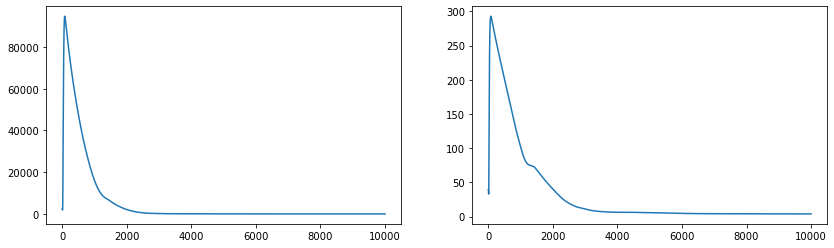

In [16]:
parameters, A3, A2 = NN_Build(eta=0.00005,
    iterations=10000,
    activation='relu',
    epsilon=0.01,
    kernel_init='he_init',
    dims=[13, 30, 10, 1],
    lam = 0.9).fit(X,y)

In [6]:
A2.shape

(10, 506)

In [7]:
A3.shape

(1, 506)

In [8]:
A2.T

array([[294.64027854,   0.        , 102.51610299, ...,  48.8908941 ,
          0.        ,  99.46518763],
       [262.57160398,   0.        , 101.75612601, ...,  15.48614448,
          0.        , 109.22114817],
       [262.87398054,   0.        ,  94.64373152, ...,  18.1152225 ,
          0.        ,  98.02365071],
       ...,
       [285.22999686,   0.        , 106.87621323, ...,  28.71380657,
          0.        , 118.53939908],
       [283.31421993,   0.        , 106.5610201 , ...,  31.02121129,
          0.        , 116.35262761],
       [283.25085287,   0.        , 106.91598078, ...,  33.1294509 ,
          0.        , 110.86569887]])

(-1.0, 1.0)

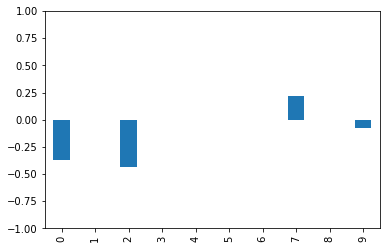

In [9]:
pd.DataFrame(np.hstack([A2.T,y])).corr().fillna(0).iloc[10,:10].plot(kind = 'bar')
plt.ylim(-1,1)

In [10]:
b = np.array([[3,4],[1,2]])

In [11]:
b ** 2

array([[ 9, 16],
       [ 1,  4]])